In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import random
plt.rcParams['figure.figsize'] = [7, 5]

In [3]:
# Pull in Data
dl = DataLib("SignalData")

LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
GDPReal = dl.pull("GDP/Real")
BondReturnIndexMonthly = BondReturnIndex.resample('1M').last()
M2 = dl.pull("M2/inUSD")

LongMinusShortRates = LongRates - ShortRates
CurveHeight = (LongRates + ShortRates) / 2

countries = LongRates.columns

In [4]:
BondReturnDiffFromWrldAvg = pd.DataFrame(columns = countries)
for country in countries:
    BondReturnDiffFromWrldAvg[country] = BondReturnIndexMonthly[country].pct_change() - BondReturnIndexMonthly.mean(axis=1).pct_change()

print(BondReturnDiffFromWrldAvg.tail())

country       AUS       DEU       CAN       ESP       FRA       ITA       JPN  \
date                                                                            
2020-04 -0.009192  0.011025  0.013757 -0.005521  0.006971 -0.019982  0.004610   
2020-05 -0.003893 -0.020277 -0.005780  0.017512 -0.008316  0.020779 -0.010755   
2020-06 -0.003958 -0.001974 -0.006194  0.002756  0.004663  0.019116 -0.008505   
2020-07 -0.004002 -0.003655 -0.003238  0.003434 -0.004365  0.012540 -0.007079   
2020-08 -0.002665 -0.000105  0.000835  0.000525  0.001406  0.001436 -0.000185   

country       CHE       GBR       USA  
date                                   
2020-04  0.016769  0.009540  0.000847  
2020-05 -0.013797 -0.000372 -0.006517  
2020-06 -0.010011 -0.006185 -0.005335  
2020-07  0.000821 -0.004335  0.003084  
2020-08 -0.000087  0.000909 -0.001656  


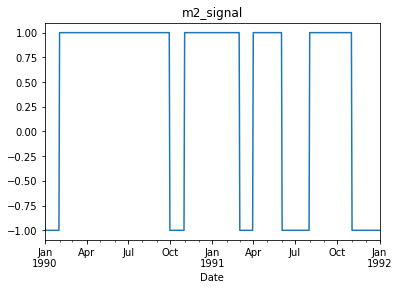

In [5]:
# Dummy Signals used for Testing

# Always Long
AlwaysLong = pd.DataFrame().reindex_like(BondReturnIndex).fillna(1)

# Always Short
AlwaysShort = pd.DataFrame().reindex_like(BondReturnIndex).fillna(-1)

# Mostly Long, Sometimes Short at Random
MostlyLong = AlwaysLong
MostlyLong.loc[MostlyLong.sample(3000).index] = -1

# Gradual Short -> Long
GradualSL = pd.DataFrame().reindex_like(BondReturnIndex).fillna(0)
num_rows, num_cols = GradualSL.shape
for col in GradualSL.columns:
    GradualSL[col] = range(0, num_rows)
GradualSL = 2 * GradualSL / num_rows - 1

# Gradual Long -> Short
GradualLS = -1 * GradualSL

# Sign of M2 Changes
M2Changes = M2.pct_change()
M2Signal = M2Changes / M2Changes.abs()
M2Signal = M2Signal.resample('1B').ffill()

M2Signal['CAN'].plot()
plt.xlabel('Date')
plt.xlim('1990-01','1992-01')
plt.title('m2_signal')
plt.show()

In [6]:
def returns(signal, returnIndex):
    return returnIndex.diff() * signal.shift(1)


def cumulativeReturns(signal, returnIndex):
    return returns(signal, returnIndex).cumsum()

# This function is never used
# Input: list of signals and list of corresponding return indexes to trade on
#        (at any point in time, absolute values of signals should add up to at most 1)
# Output: cumulative returns based on this trading strategy
def cumulativeReturnsMultiSignal(signals, returnIndexes):
    assert(max(sum([signal.abs() for signal in signals])) <= 1)
    
    totalCR = returnIndexes[0].copy() * 0
    for i in range(len(signals)):
        totalCR += cumulativeReturns(signals[i], returnIndexes[i])
    return totalCR

def plotCumulativeReturns(signal, returnIndex, title=''):
    Returns = cumulativeReturns(signal, returnIndex)
    Returns.plot()
    returnIndex.diff().cumsum().plot()
    plt.xlim('1980-01','2020-06')
    plt.legend(['Returns Using Signal', 'Return Index'])
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
def plotCumulativePL(signal, returnIndex, title=''):
    Returns = cumulativeReturns(signal, returnIndex)
    (Returns - returnIndex).plot()
    plt.xlim('1980-01','2020-06')
    plt.legend('Cumulative P&L')
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
def percentReturns(signal, returnIndex, rolling_window):
    return returnIndex.pct_change(rolling_window) * signal.shift(1)

# def plotReturns(signal, returnIndex, rolling_window, title=''):
#     Returns = percentReturns(signal, returnIndex, rolling_window)
#     Returns.plot()
#     returnIndex.pct_change(rolling_window).plot()
#     plt.axhline(y=0, color='grey', linestyle='-')
#     plt.xlim('1980-01','2020-06')
#     plt.legend(['Returns Using Signal for Country' + country, 'Returns for Country ' + country])
#     plt.xlabel('Date')
#     plt.title(title)
#     plt.show()

date
2020-07-28    327.060539
2020-07-29    325.523991
2020-07-30    328.099044
2020-07-31    326.611887
2020-08-03    326.723845
Freq: B, Name: GBR, dtype: float64


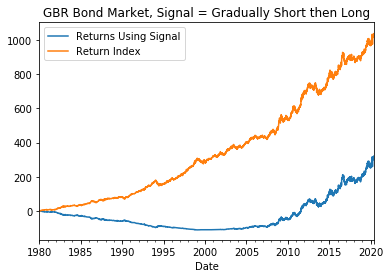

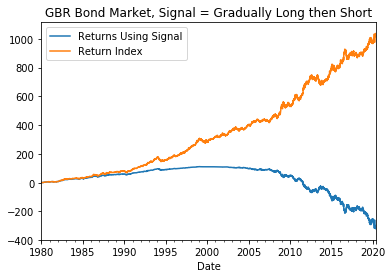

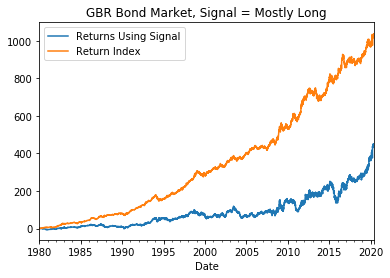

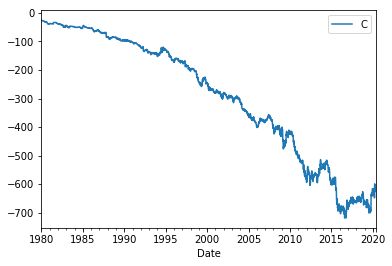

In [7]:
print(cumulativeReturnsMultiSignal([.5 * GradualSL['GBR'], .5 * GradualSL['GBR']], [BondReturnIndex['GBR'], BondReturnIndex['GBR']]).tail())

plotCumulativeReturns(GradualSL['GBR'], BondReturnIndex['GBR'], 'GBR Bond Market, Signal = Gradually Short then Long')
plotCumulativeReturns(GradualLS['GBR'], BondReturnIndex['GBR'], 'GBR Bond Market, Signal = Gradually Long then Short')
plotCumulativeReturns(MostlyLong['GBR'], BondReturnIndex['GBR'], 'GBR Bond Market, Signal = Mostly Long')
plotCumulativePL(MostlyLong['GBR'], BondReturnIndex['GBR'])

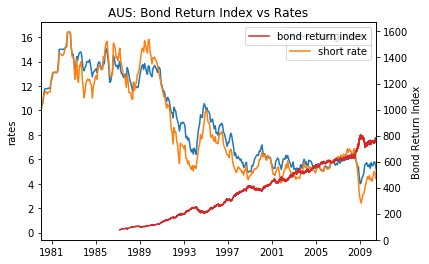

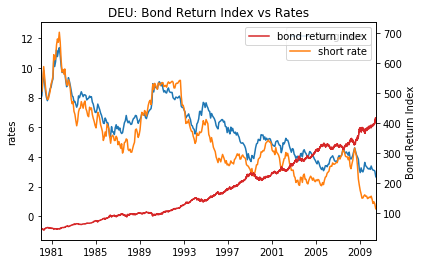

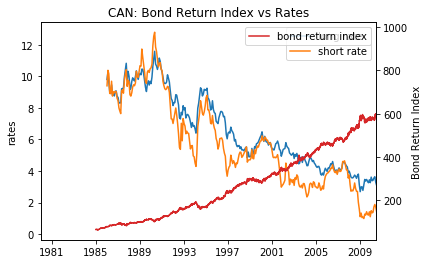

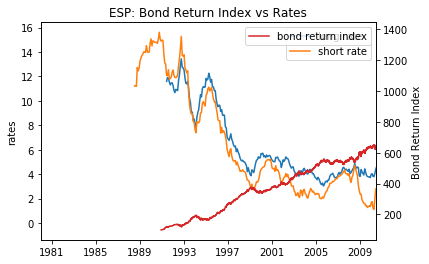

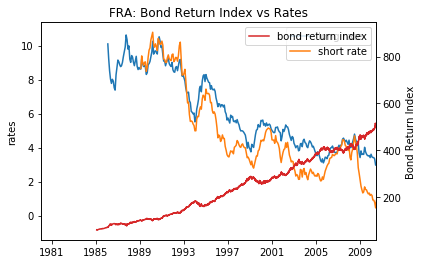

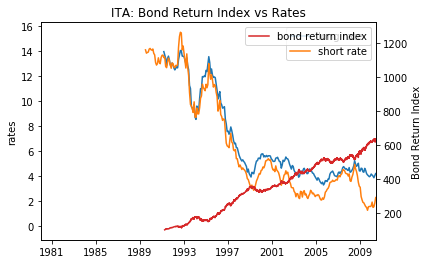

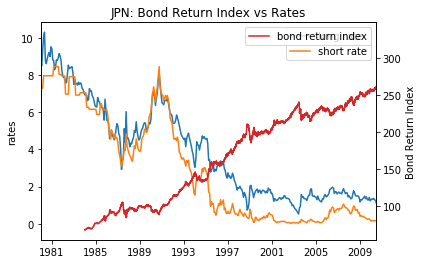

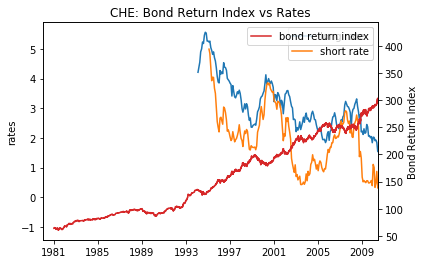

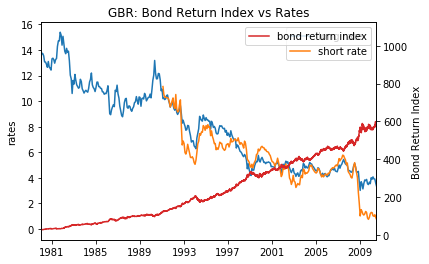

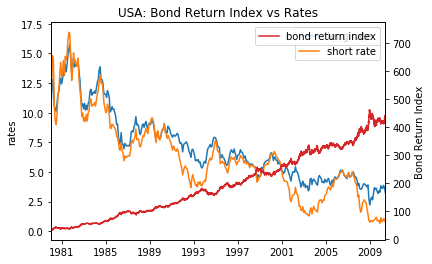

In [9]:
# Visualize bond returns for each country vs long/short rate
for country in BondReturnIndexMonthly.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(LongRates[country].to_timestamp(), label = 'long rate')
    ax1.plot(ShortRates[country].to_timestamp(), label = 'short rate')
    ax1.set_ylabel("rates")
    ax1.legend()
    ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = "bond return index")
    ax2.set_ylabel('Bond Return Index')
    ax2.legend()
    plt.title(country + ': Bond Return Index vs Rates')
    plt.xlim('1980-01','2010-06')
    plt.show()

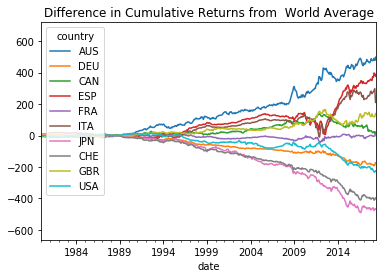

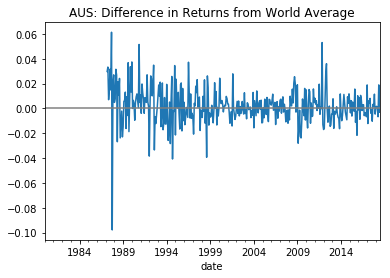

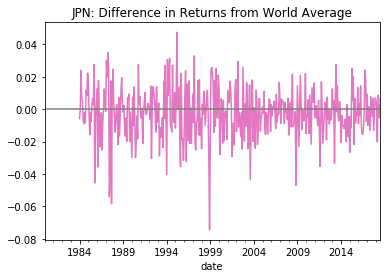

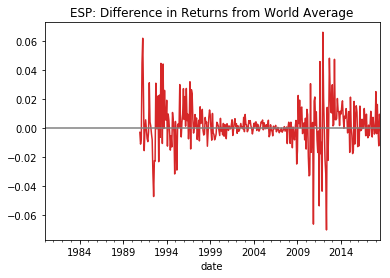

In [10]:
# Difference in returns from world average

CumBondReturnDifferenceFromWrldAvg = pd.DataFrame().reindex_like(BondReturnIndexMonthly)
for country in countries:
    CumBondReturnDifferenceFromWrldAvg[country] = BondReturnIndexMonthly[country] - BondReturnIndexMonthly.mean(axis=1)

CumBondReturnDifferenceFromWrldAvg.plot()
plt.title('Difference in Cumulative Returns from  World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['AUS'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('AUS: Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['JPN'].plot(color = 'tab:pink')
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('JPN: Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

BondReturnDiffFromWrldAvg['ESP'].plot(color = 'tab:red')
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('ESP: Difference in Returns from World Average')
plt.xlim('1980-01','2018-06')
plt.show()

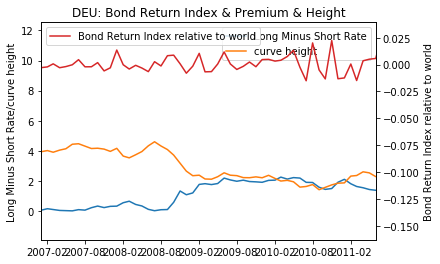

In [11]:
# Research Indicator 1 (Bond Premium = Long-Short Rates & Curve Height)
example_countries = ['DEU']

for country in example_countries:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Long Minus Short Rate'
    LongMinusShortRateDifference = LongMinusShortRates[country] - LongMinusShortRates.mean(axis=1)
    CurveHeightDifference = CurveHeight[country] - CurveHeight.mean(axis=1)
    ax1.plot(LongMinusShortRates[country].to_timestamp(), label = ax1_label)
    ax1.plot(CurveHeight[country].to_timestamp(), label = 'curve height')
    ax1.set_ylabel(ax1_label + "/curve height")
    ax1.legend()
    ax2_label = 'Bond Return Index relative to world'
    ax2.plot(BondReturnDiffFromWrldAvg[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + ': Bond Return Index & Premium & Height')
    plt.xlim('2007-01','2011-06')
    plt.show()

In [15]:
# Time-series cross-correlation from https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

# For single country, computes correlation of pct_change in series1 with specific window 
# and returns of series2 with a specific rolling window with future lags up to max_lag
#
# series: indicator data series
# country for comparison
# change_months: how many months for percent change for indicator
# return_months: how many months for computing returns
# max_lag: how many lagging months you want to test correlations for
# output: list of correlations between series for lag = 0 to max_lag
def computeCorrStats(series1, series2, country, change_months, return_months, max_lag):
    x = series2[country].pct_change(return_months)
    y = series1[country].pct_change(change_months)
    return [crosscorr(x, y, lag) for lag in range(return_months, return_months + max_lag)]

def computeCorrWithBondReturns(series, country, change_months, return_months, max_lag):
    return computeCorrStats(series, BondReturnIndexMonthly, country, change_months, return_months, max_lag)

def computeCorrWithBondReturnDiffs(series, country, change_months, return_months, max_lag):
    return computeCorrStats(series, BondReturnDiffFromWrldAvg, country, change_months, return_months, max_lag)


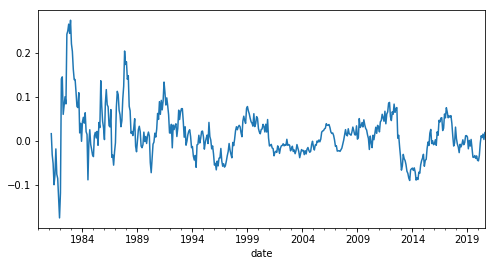

Difference in LongMinusShortRates from global average as predictor?
AUS: Max corr of -0.03988600163800253 with 1-month change in bond return differential
DEU: Max corr of -0.03439299736591181 with 7-month change in bond return differential
CAN: Max corr of -0.0368702244089795 with 1-month change in bond return differential
ESP: Max corr of 0.009476694289009003 with 6-month change in bond return differential
FRA: Max corr of -0.04060943302064921 with 6-month change in bond return differential
ITA: Max corr of -0.03816755934119542 with 1-month change in bond return differential
JPN: Max corr of 0.07722947233414232 with 2-month change in bond return differential
CHE: Max corr of 0.060869103661075986 with 4-month change in bond return differential
GBR: Max corr of -0.04343134922307188 with 21-month change in bond return differential
USA: Max corr of 0.04348386613742495 with 9-month change in bond return differential


In [48]:
# Research on predictive power of LongMinusShortRates

# Compute X-month change in bond return differential between country C and global average
XMonthChanges = {}
maxMonths = 24

for months in range(maxMonths):
    BondReturnDiffFromWrldAvg = pd.DataFrame(columns = countries)
    for country in countries:
        BondReturnDiffFromWrldAvg[country] = BondReturnIndexMonthly[country].pct_change(months) - BondReturnIndexMonthly.mean(axis=1).pct_change(months)
    XMonthChanges[months] = BondReturnDiffFromWrldAvg

# Difference in LongMinusShortRates from world average?
LongMinusShortRatesDiffs = pd.DataFrame(columns=countries)

# Want to compute correlation between
# A) difference in bond premium between country C and global average
# & B) X-month change in bond return differential between country C and global average

XMonthChanges[14]['GBR'].plot()
plt.show()

print("Difference in LongMinusShortRates from global average as predictor?")
for country in countries:
    # Compute country difference in bond premium from global average
    LongMinusShortRatesDiffs[country] = LongMinusShortRates[country] - LongMinusShortRates.mean(axis=1)

    # Compute cross-correlations between bond index returns and difference in bond premium from global average
    corrs1 = [crosscorr(XMonthChanges[i][country], LongMinusShortRatesDiffs[country], lag=i) for i in range(1,maxMonths)]
    print(country + ': Max corr of ' + str(max(corrs1)) + ' with ' + str(1 + np.argmax(corrs1)) + '-month change in bond return differential')
    
# THE BELOW CODE IS NOW INCORRECT
# Want to compute correlation between
# A) X-month change in difference in bond premium between country C and global average
# & B) Y-month difference in future returns for country C and global average
    
# Monthly change in Difference in LongMinusShortRates from world average?
# for i in range(1, 13):
#     print("\n" + str(i) + "-month change in Difference in LongMinusShortRates from global average?")
#     for country in example_countries:
#         LongMinusShortRatesDiffsChange = LongMinusShortRatesDiffs.pct_change(i)

#         # Compute cross-correlations between bond index returns and difference in bond premium from global average
#         corrs1 = [crosscorr(BondReturnDiffFromWrldAvg[country], LongMinusShortRatesDiffsChange[country], lag=i) for i in range(24)]
#         print(country + ': Max corr of ' + str(max(corrs1)) + ' with lag of ' + str(np.argmax(corrs1)) + ' months')

In [17]:
# Never finished - Create Indicator for DEU out of Changes in LongMinusShortRatesDiff combined with Curve Height
# linear_regressor = LinearRegression()
# linear_regressor.fit(LongMinusShortRatesDiffsChange['DEU'], )

Correlations for 6-month fxVsUSD change and 1-month returns with 0, 1, ...  5-month lag
[-0.011731395695858769, -0.014834182644451285, 0.0009343634062876896, -0.001371652431629279, 0.003034123088419384, 0.0010304528511821199]
Correlations for 6-month fxVsUSD change and 2-month returns with 0, 1, ...  5-month lag
[-0.017591463143028944, -0.009123620331947073, 9.29074108687076e-05, 0.0015753156550374246, 0.003756202236764585, 0.011135262204814304]
Correlations for 6-month fxVsUSD change and 3-month returns with 0, 1, ...  5-month lag
[-0.013217060959256666, -0.00786720252581843, 0.001045804470118819, 0.0010146700287122202, 0.010508591062454158, 0.01679965443449798]
Correlations for 6-month fxVsUSD change and 4-month returns with 0, 1, ...  5-month lag
[-0.01249252369274971, -0.006715910829938202, 3.281583234144111e-05, 0.0071418871755910334, 0.015636816437759472, 0.007639289032460418]
Correlations for 6-month fxVsUSD change and 5-month returns with 0, 1, ...  5-month lag
[-0.010921224744

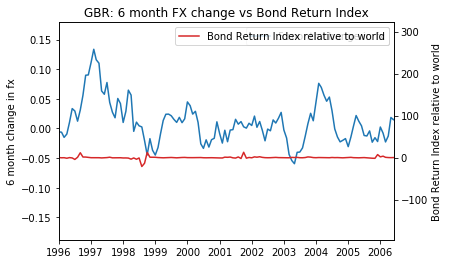

In [18]:
# Let's work on currency appreciation over last 6 months as predictor of country's positive bond performance
fxVsUSD = dl.pull("fxVsUSD")
fxTrdWts = dl.pull("fxTrdWts/Nominal")

# And let's just work with GBR
example_countries = ['GBR']

for return_window in range(1,12):
    print("Correlations for 6-month fxVsUSD change and " + str(return_window) + "-month returns with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturns(fxVsUSD, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month returns with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturns(fxTrdWts, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month return diffs with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturnDiffs(fxVsUSD, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")
    
for return_window in range(1,12):
    print("Correlations for 6-month fxTrdWts change and " + str(return_window) + "-month return diffs with 0, 1, ...  5-month lag")
    print(computeCorrWithBondReturnDiffs(fxTrdWts, 'GBR', 6, return_window, 6))
print("\n----------------------------------------\n")

# Compute 6-month change in fx vs Bond Return Index
for country in example_countries:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '6 month change in FX'
    ax1.plot(fxTrdWts[country].pct_change(6).to_timestamp(), label = '5 month change in fx')
    ax1.set_ylabel('6 month change in fx')
    ax1.legend()
    ax2_label = 'Bond Return Index relative to world'
    ax2.plot(BondReturnDiffFromWrldAvg[country].pct_change(3).to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + ': 6 month FX change vs Bond Return Index')
    plt.xlim('1996-01','2006-06')
    plt.show()

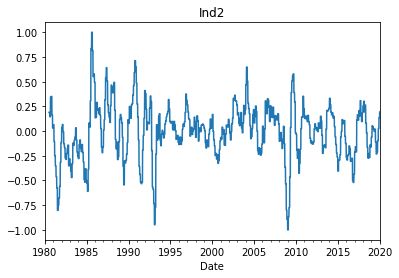

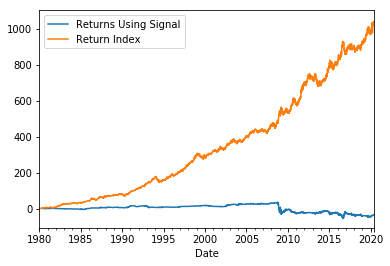

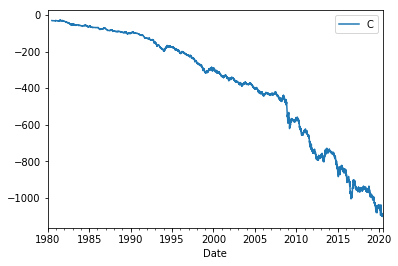

In [20]:
# Create Indicator out of Long - Short & Curve Height, fx appreciation
# (First Pass -- very sumb signals)
Ind1 = LongMinusShortRates.mean() - LongMinusShortRates + CurveHeight.mean() - CurveHeight
Ind2 = fxVsUSD.pct_change(6)

# Resample to business days
Ind1 = Ind1.resample('1B').ffill()
Ind2 = Ind2.resample('1B').ffill()

# Normalize (min-max) Ind 1
Ind1 = 2 * ((Ind1 - Ind1.min()) / (Ind1.max() - Ind1.min())) - 1
Ind2 = 2 * ((Ind2 - Ind2.min()) / (Ind2.max() - Ind2.min())) - 1

# Plot
Ind2['GBR'].plot()
plt.xlabel('Date')
plt.xlim('1980-01','2020-01')
plt.title('Ind2')
plt.show()

# Show Returns for Ind2
plotCumulativeReturns(Ind2['GBR'], BondReturnIndex['GBR'])
plotCumulativePL(Ind2['GBR'], BondReturnIndex['GBR'])
# plotReturns(Ind2['GBR'], BondReturnIndex['GBR'], 1)

## Shift Gears for Different Focus

# Research on Betting on Global Bonds vs Relative Country Positions (Aug 10-11)

In [33]:
# Trading on global bond return
GlobalBondReturnsMonthly = BondReturnIndexMonthly.mean(axis=1)

# or trading on difference in country's returns from world average (relative position)
CumBondReturnDifferenceFromWrldAvg

# Creates signal of perfect trades if you know the return `periods` periods into the future with certainty
# If you are trading relative with a country, the trades are weighted by 0.5 because to capture those returns,
# you need to long the counry/short global or vice versa)
def perfectTrades(periods, returnIndex, relativePosStrategy=False):
    
    PerfectTrades = returnIndex.pct_change(periods)
    PerfectTrades /= PerfectTrades.abs()
    
    # pct_change gives a positive value for -10 -> -15 and a negative value for -10 -> -5
    # we want the opposite in our trades, so we will flip pct changes if the previous value in the original series < 0
    indicesToFlip = returnIndex.index[returnIndex < 0].shift(1)
    
    # Make sure we don't go out of bounds
    indicesToFlip = indicesToFlip.intersection(PerfectTrades.index)
    
    # Flip them
    PerfectTrades[indicesToFlip] *= -1
    
    # If we're trading on the position of a country's returns relative to world average,
    # we can only keep half the movement in the CumBondReturnDifferenceFromWrldAvg index
    if relativePosStrategy:
        PerfectTrades *= 0.5
    
    PerfectTrades = PerfectTrades.shift(-periods)
    return PerfectTrades

# Creates signal of biased approximately perfect trades if you know the return `periods` periods into the future 
# with probability p if market goes up and probability q if market goes down
def biasedApproxPerfectTrades(periods, returnIndex, p, q, relativePosStrategy=False):
    PerfectTrades = perfectTrades(periods, returnIndex, relativePosStrategy)
    for date in PerfectTrades.index:
        if PerfectTrades[date] == 1 and random.random() > p:
            PerfectTrades[date] = -1
        elif PerfectTrades[date] == -1 and random.random() > q:
            PerfectTrades[date] = 1
    return PerfectTrades

# Creates signal of approximately perfect trades if you know the return 
# `periods` periods into the future with probability p
def approxPerfectTrades(periods, returnIndex, p, relativePosStrategy=False):
    return biasedApproxPerfectTrades(periods, returnIndex, p, p, relativePosStrategy)

# Input: monthList: list of different amounts of months out for return knowledge, ie: [12, 24]
#        returnIndex: return index to trade
#        p: probability you know return in the future if market goes up in reality
#        q: probability you know return in the future if market goes down in reality
# Output: dictionary with cumulative returns for each month in monthList
#         {12: cumulative returns for trading on 12 months out with p and q, 
#          24: cumulative returns for trading on 24 months out with p and q}
def cumBiasedApproxPerfectReturns(monthList, returnIndex, p, q, relativePosStrategy=False):
    CumBiasedApproxPerfectReturns = {}
    for months in monthList:
        BiasedApproxPerfectTrades = biasedApproxPerfectTrades(months, returnIndex, p, q, relativePosStrategy)
        CumBiasedApproxPerfectReturns[months] = cumulativeReturns(BiasedApproxPerfectTrades, returnIndex)
    return CumBiasedApproxPerfectReturns

# Input: monthList: list of different amounts of months out for return knowledge, ie: [12, 24]
#        returnIndex: return index to trade
#        p: probability you know return in the future if market goes up in reality
#        q: probability you know return in the future if market goes down in reality
#        benchmark: return index to show as benchmark
# Output: graph of cumulative returns for each trading scenario
def plotCumBiasedApproxPerfectReturns(monthList, returnIndex, p, q, title, 
                                      ymin=-50, ymax=2000, 
                                      benchmark=GlobalBondReturnsMonthly, benchmarkName='Global Bond Returns', 
                                      relativePosStrategy=False):
    legend = []
    CumBiasedApproxPerfectReturns = cumBiasedApproxPerfectReturns(monthList, returnIndex, p, q, relativePosStrategy)
    for months in CumBiasedApproxPerfectReturns:
        CumBiasedApproxPerfectReturns[months].plot()
        legend.append('Returns knowing ' + str(months) + ' months out')
    
    # Plot benchmark cumulative returns starting from first valid index of return stream
    firstDate = returnIndex.first_valid_index()
    benchmark.loc[firstDate:].diff().cumsum().plot()
    legend.append('Benchmark: ' + benchmarkName)
    
    plt.legend(legend, loc='upper left')
    plt.xlim(firstDate,'2020-06')
    plt.ylim(ymin,ymax)
    plt.xlabel('Date')
    plt.title(title)
    plt.show()
    
def cumApproxPerfectReturns(monthList, returnIndex, p, relativePosStrategy=False):
    return cumBiasedApproxPerfectReturns(monthList, returnIndex, p, p, relativePosStrategy)

def cumPerfectReturns(monthList, returnIndex, relativePosStrategy=False):
    return cumBiasedApproxPerfectReturns(monthList, returnIndex, 1, 1, relativePosStrategy)
    
def plotCumApproxPerfectReturns(monthList, returnIndex, p, title, 
                                benchmark=GlobalBondReturnsMonthly, benchmarkName='Global Bond Returns', 
                                ymin=-50, ymax=2000, relativePosStrategy=False):
    return plotCumBiasedApproxPerfectReturns(monthList, returnIndex, p, p, title, ymin, ymax, 
                                             benchmark, benchmarkName, relativePosStrategy)
    
def plotCumPerfectReturns(monthList, returnIndex, title, 
                          benchmark=GlobalBondReturnsMonthly, benchmarkName='Global Bond Returns', 
                          ymin=-50, ymax=2000, relativePosStrategy=False):
    return plotCumBiasedApproxPerfectReturns(monthList, returnIndex, 1, 1, title, ymin, ymax, 
                                             benchmark, benchmarkName, relativePosStrategy)

# List of months out for futue visualizations
MonthList = [1, 3, 6, 12, 24, 48]


In [28]:
# Smaller visualizations (going to have a lot coming up!)
plt.rcParams['figure.figsize'] = [8, 4]

### What do returns look like if you had perfect information about an individual country's bond return index X time into the future? (Australia - best & Japan - worst)

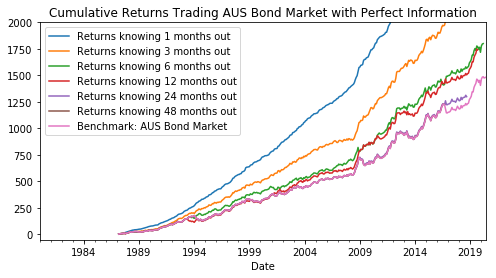

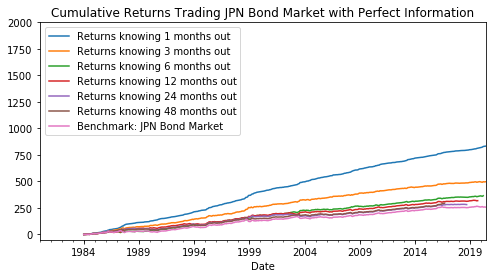

In [31]:
plotCumPerfectReturns(MonthList, BondReturnIndexMonthly['AUS'], 
                      'Cumulative Returns Trading AUS Bond Market with Perfect Information', 
                      benchmark = BondReturnIndexMonthly['AUS'],
                      benchmarkName = 'AUS Bond Market', 
                      ymax=2000)
plotCumPerfectReturns(MonthList, BondReturnIndexMonthly['JPN'], 
                      'Cumulative Returns Trading JPN Bond Market with Perfect Information', 
                      benchmark = BondReturnIndexMonthly['JPN'],
                      benchmarkName = 'JPN Bond Market',  
                      ymax=2000)

 ### What do returns look like if you had perfect information about the global bond return index X months into the future?

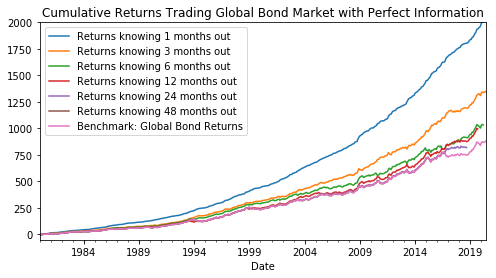

Average Annual Return for 1 months out: 1.1033946965439592
Average Annual Return for 3 months out: 1.0927948922507744
Average Annual Return for 6 months out: 1.086087268300388
Average Annual Return for 12 months out: 1.0862448175392345
Average Annual Return for 24 months out: 1.0830843591057062
Average Annual Return for 48 months out: 1.0862335257165965


In [265]:
plotCumPerfectReturns(MonthList, GlobalBondReturnsMonthly, 'Cumulative Returns Trading Global Bond Market with Perfect Information')

# TODO: turn this ARR computation into function above
# Compute effective annualized return rates for each strategy
CumPerfectReturns = cumPerfectReturns(MonthList, GlobalBondReturnsMonthly)
InitialCapital = GlobalBondReturnsMonthly[0]
InitialDate = GlobalBondReturnsMonthly.first_valid_index()
for months in CumPerfectReturns:
    cprm = CumPerfectReturns[months]
    FinalDate = cprm.last_valid_index()
    FinalCumReturns = cprm[FinalDate]
    TotalMonths = (FinalDate - InitialDate).n
    AAR = (FinalCumReturns/InitialCapital) ** (12 / TotalMonths)
    print("Average Annual Return for " + str(months) + " months out: " + str(AAR))
    

### What do returns look like if you had <i>approximately</i> perfect information (equal error for when market moves up or down) about the global bond return index X months into the future?

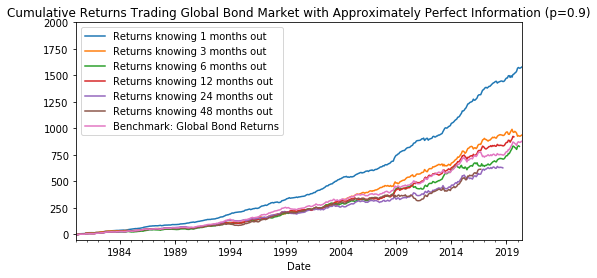

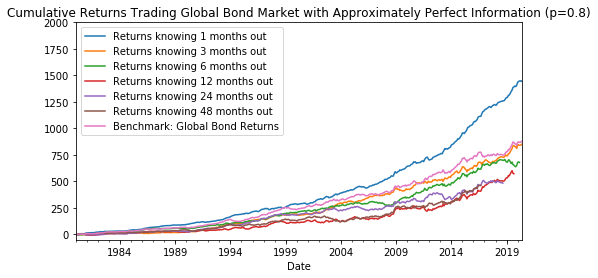

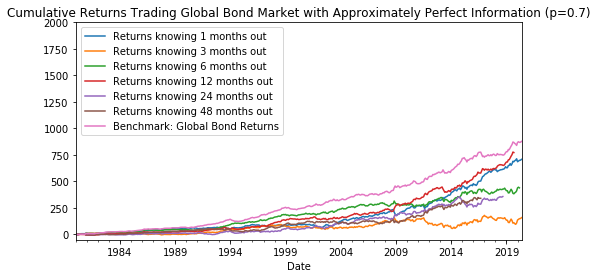

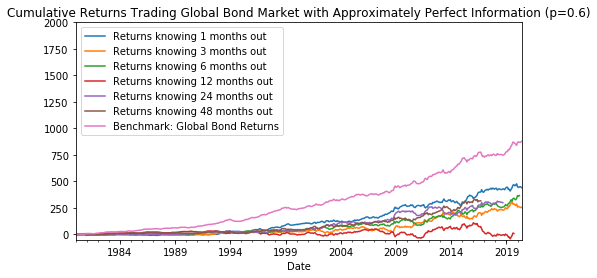

In [279]:
probs = [.9, .8, .7, .6]

for p in probs:
    plotCumApproxPerfectReturns(MonthList, GlobalBondReturnsMonthly, p, 
                            'Cumulative Returns Trading Global Bond Market with Approximately Perfect Information (p=' + str(p) + ')')

# TODO: these line charts currently involve randomness, so make some that include expected error bars like these:
# https://stackoverflow.com/questions/43701489/how-to-plot-a-line-chart-with-error-values-in-matplotlib
# https://www.absentdata.com/python-graphs/seaborn-line-chart/

### What do returns look like if you had <i>biased approximately</i> perfect information (prob p of being correct for when market moves up/prob q of being correct when market moves down) about the global bond return index X months into the future?

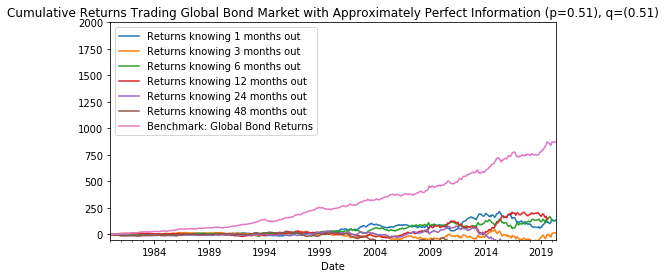

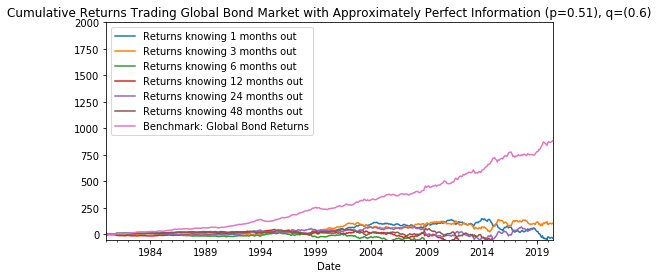

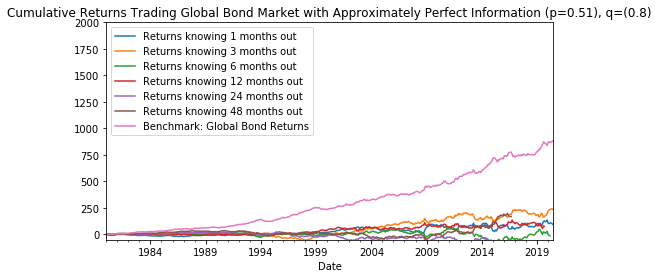

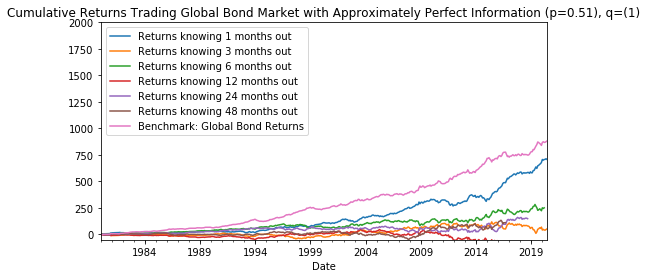

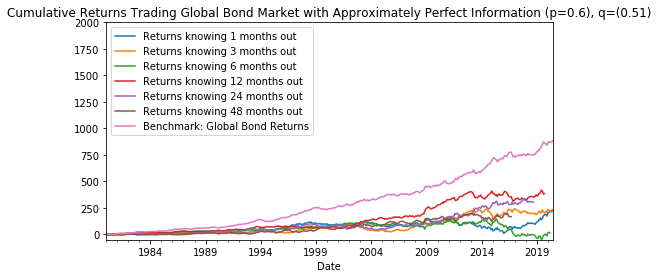

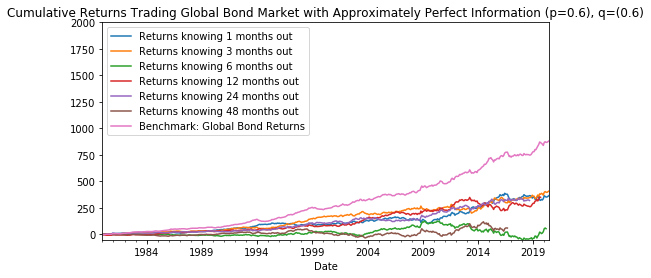

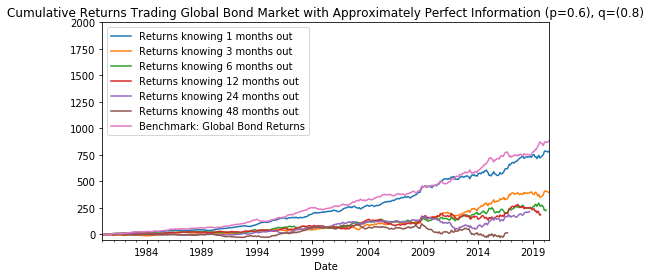

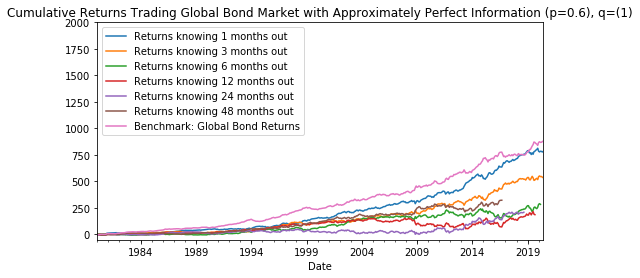

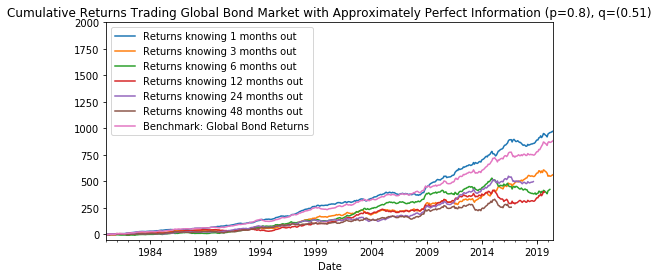

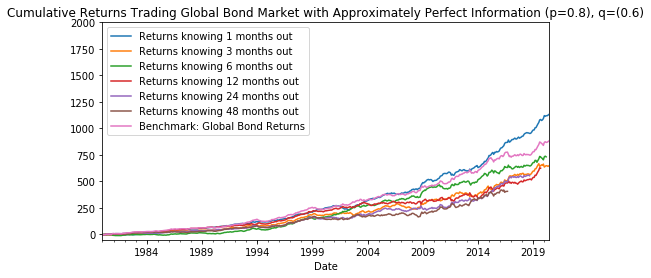

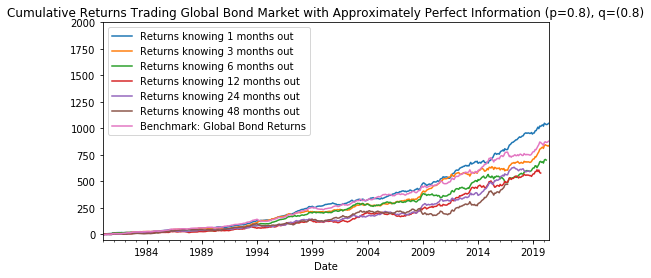

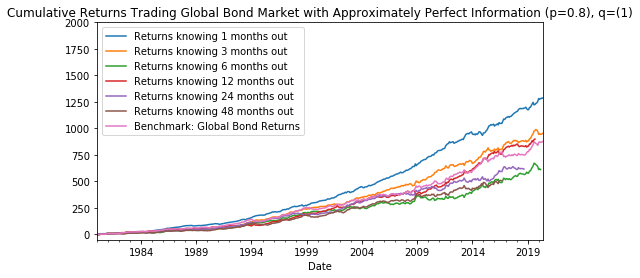

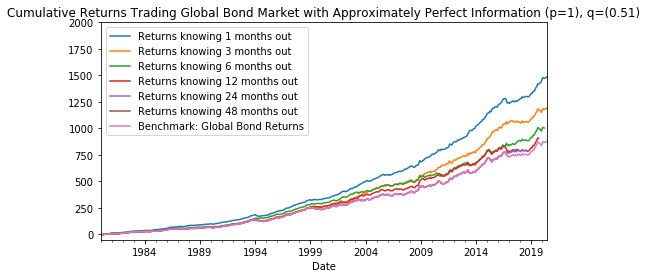

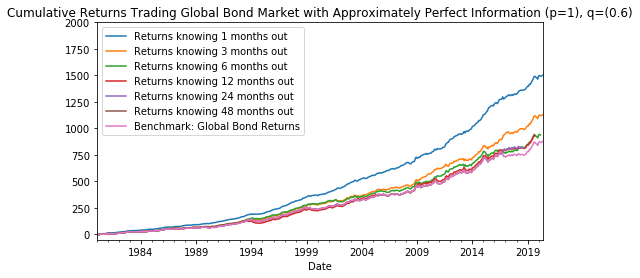

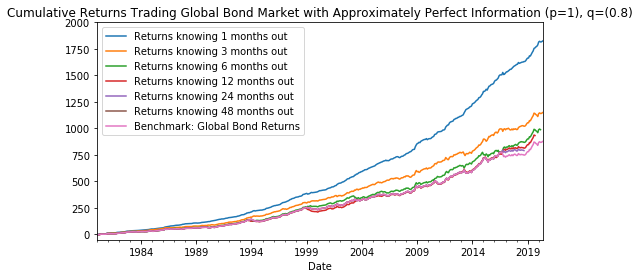

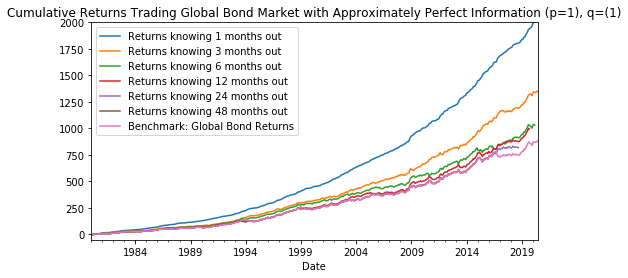

In [280]:
plt.rcParams['figure.figsize'] = [8, 4]
probs = [.51, .6, .8, 1]

for p in probs:
    for q in probs:
        plotCumBiasedApproxPerfectReturns(MonthList, GlobalBondReturnsMonthly, p, q, 
                                          'Cumulative Returns Trading Global Bond Market with Approximately Perfect Information (p=' + str(p) + '), q=(' + str(q) + ')')


In [236]:
# Generate table of p x q combos and their respective comparison to benchmark (colored by magnitude difference)
# Of course, this would best with annual effective returns compared to benchmark, but for now it'll have to be based
# on nominal differences in returns because that's how I've been working

# Generate square table with rows/columns as [0.5, 0.55, ... .95, 1]
probs = [round(.5 + i/20, 2) for i in range(11)]
pqTable = pd.DataFrame(index = probs, columns = probs)

# Let's base this table on the last possible date that return streams from 1 - 24 months share
# (24 months before end 2020-08 plus one month for shift)
lastMonth = '2018-09'
benchMarkReturn = GlobalBondReturnsMonthly[lastMonth]

# Input: periods: how many periods into the future you have knowledge of
#        trials: how many times you want to run simulations with pq (larger values = longer runtime)
# Output: pqTable knowing returns `periods` periods into the future
# with prob p for market increases and prob q for market decrease
def generatePQTable(periods, trials):    
    for p in pqTable.columns:
        for q in pqTable.index:
            avgDiffFromBenchMark = 0
            for i in range(trials):
                pqReturns = cumBiasedApproxPerfectReturns([periods], GlobalBondReturnsMonthly, p, q)[periods]
                avgDiffFromBenchMark += (pqReturns[lastMonth] - benchMarkReturn)/trials
            pqTable[p][q] = avgDiffFromBenchMark
    return pqTable

In [237]:
# Heat map code taken from here:
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, valfmt(data[i, j], None))
            texts.append(text)

    return texts

Heatmap for returns on 2018-09 compared to benchmark for knowing 1 months out


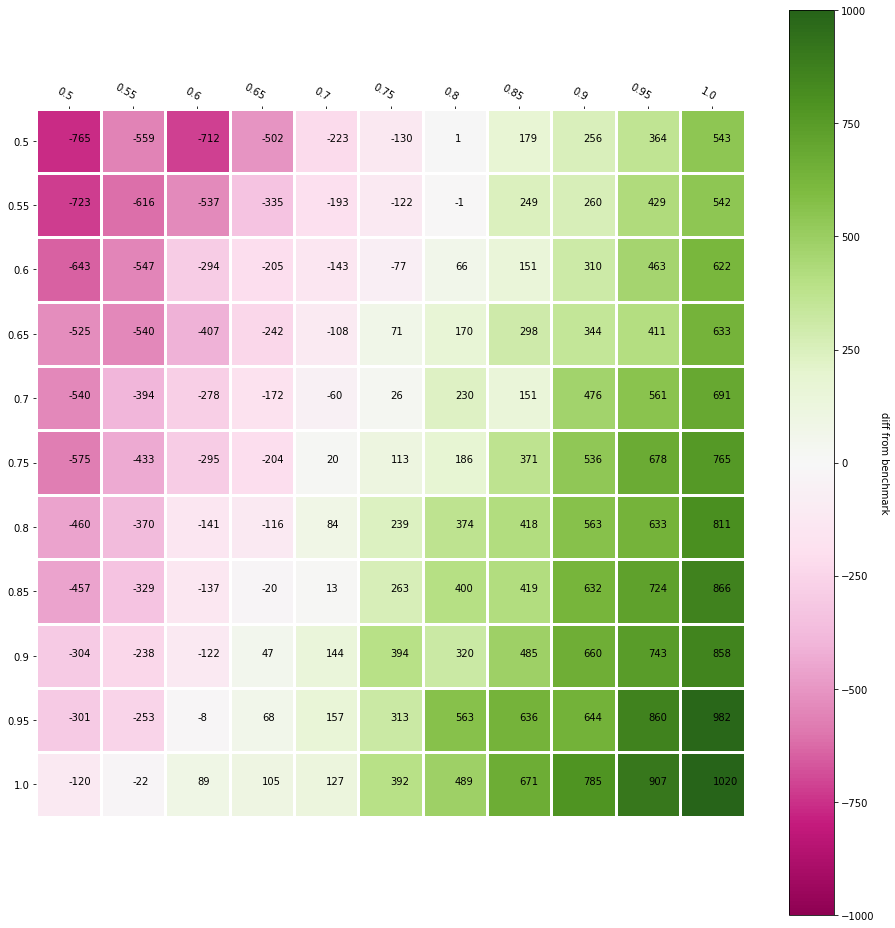

Heatmap for returns on 2018-09 compared to benchmark for knowing 3 months out


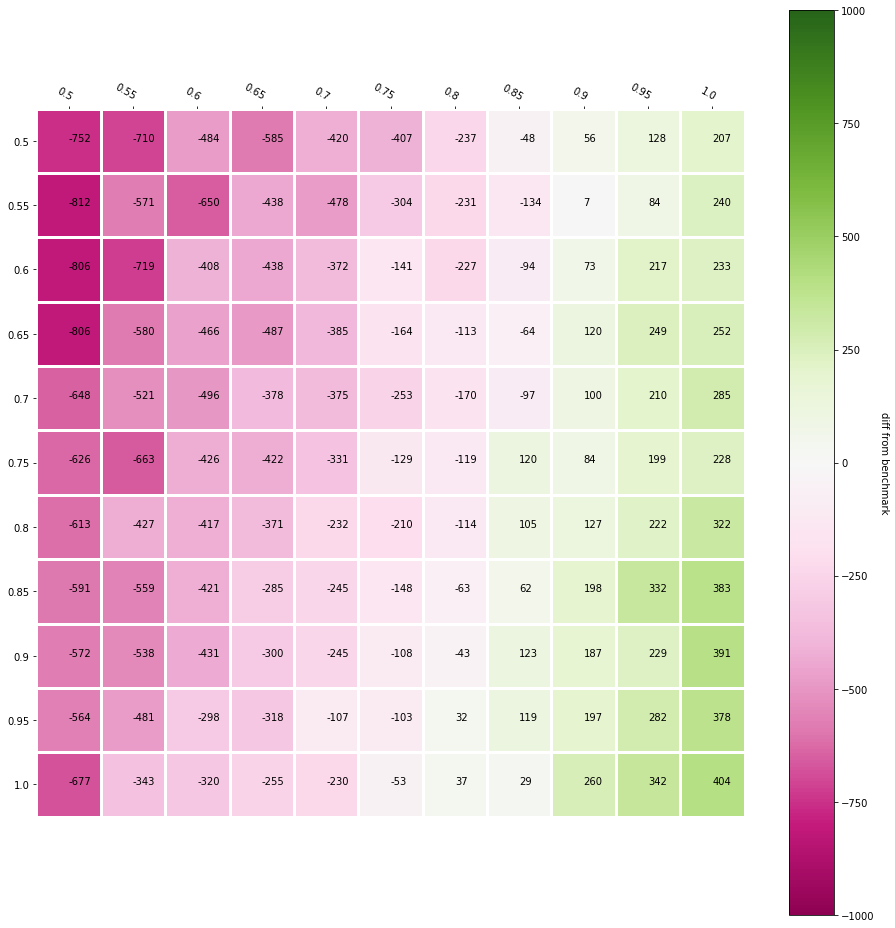

Heatmap for returns on 2018-09 compared to benchmark for knowing 6 months out


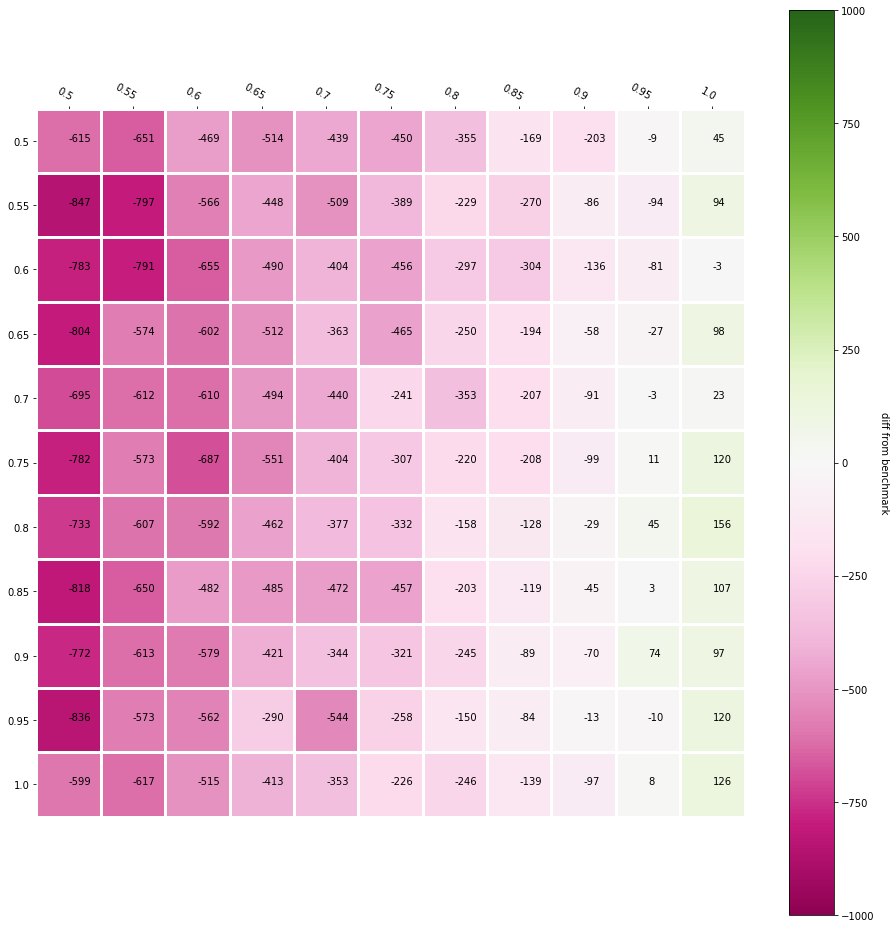

Heatmap for returns on 2018-09 compared to benchmark for knowing 12 months out


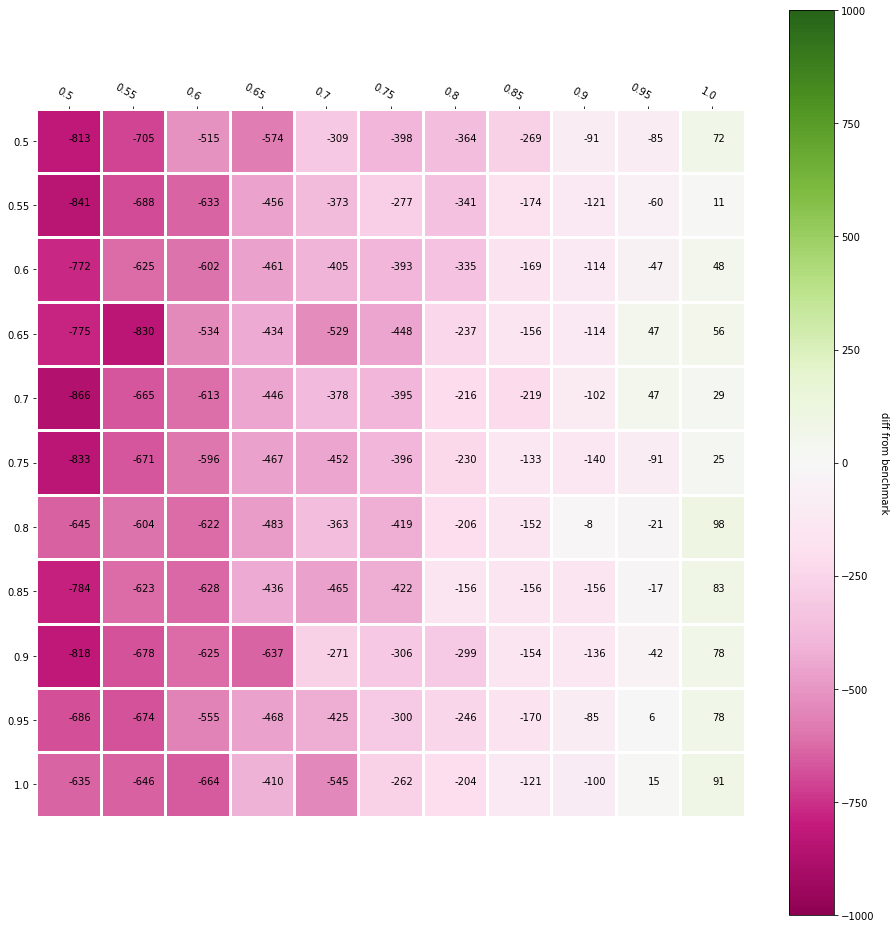

Heatmap for returns on 2018-09 compared to benchmark for knowing 24 months out


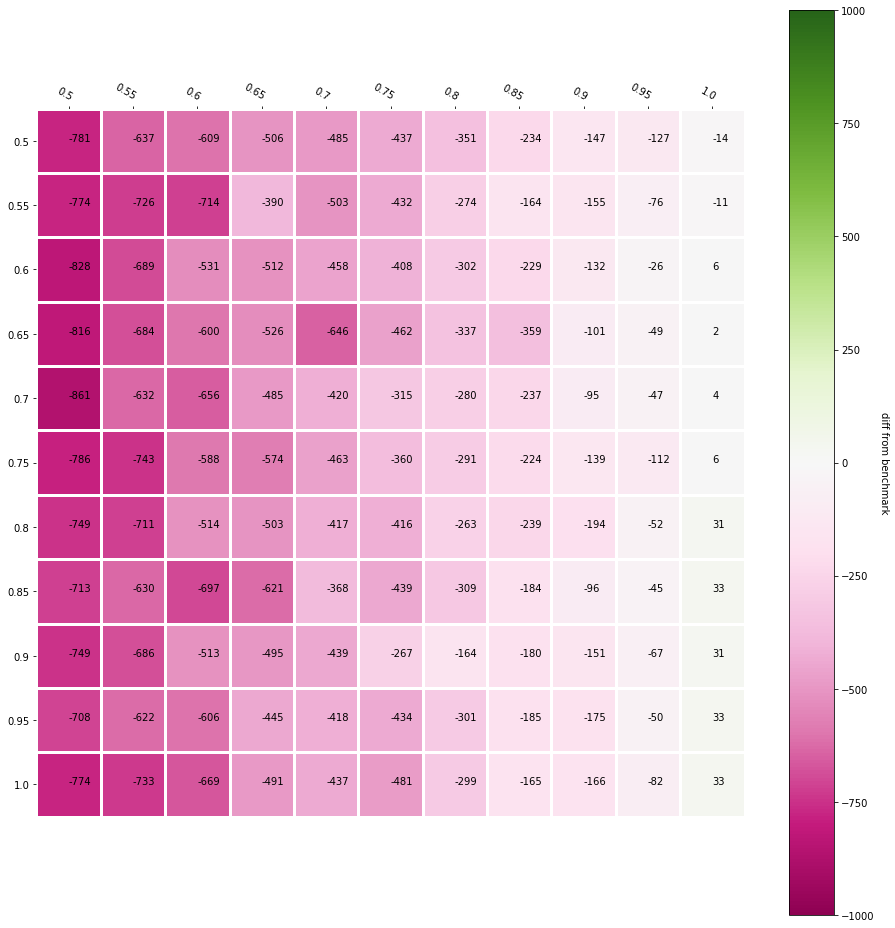

Heatmap for returns on 2018-09 compared to benchmark for knowing 48 months out


<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/andzuck/.local/share/virtualenvs/Intership2020-Iv1jtUG8/lib/python3.6/site-packages/numpy/ma/core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/andzuck/.local/share/virtualenvs/Intership2020-Iv1jtUG8/lib/python3.6/site-packages/matplotlib/ticker.py:426: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


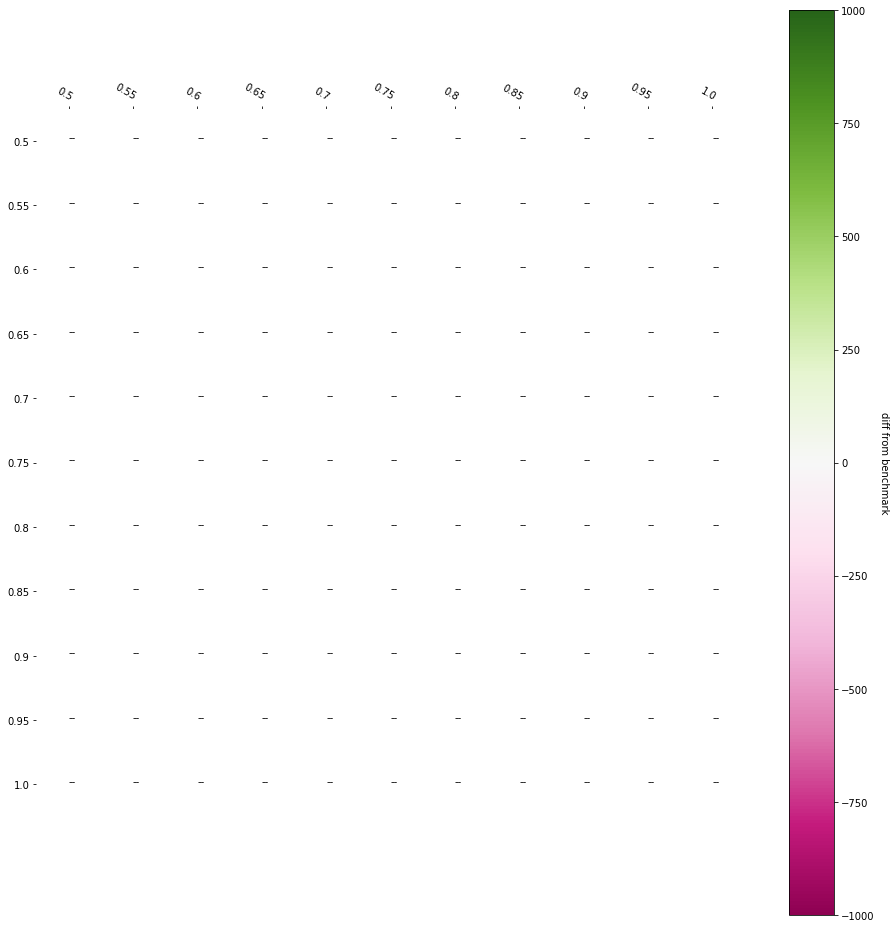

In [240]:
# Generate pqTables for each lead time in MonthList

for months in MonthList:
    print("Heatmap for returns on 2018-09 compared to benchmark for knowing " + str(months) + " months out")
    pqTable = generatePQTable(months, 3)
    
    vals = pqTable.astype(float).round()

    fig, ax = plt.subplots(figsize=(13,13))
    im, cbar = heatmap(vals, pqTable.index, pqTable.columns, ax=ax,
                       cmap="PiYG", cbarlabel="diff from benchmark",
                       vmin=-1000,vmax=1000)
    texts = annotate_heatmap(im, valfmt="{x:.0f}", textcolors=["black"])

    fig.tight_layout()
    plt.show()

In [134]:
# TODO
# Currently p = 0.8 means prob(you correctly bet long | market goes up)
# We should also consider a different version of the prob values....
# p = 0.8 means prob(market goes up | you bet market goes up)

### What do returns look like if you had perfect information about the change in a country's relative position X time into the future? (Using Bond Prospectus Strategy)

In [51]:
# WOW! This cleared up 2 hours of confusion.... 
# percent change leaving a negative number is opposite what you would expect visually
# (it's mathematically accurate, not visually accurate)
x = pd.Series([-5,-6,-3,9,3,-4,0,-5,0,6])
x.pct_change()

0         NaN
1    0.200000
2   -0.500000
3   -4.000000
4   -0.666667
5   -2.333333
6   -1.000000
7        -inf
8   -1.000000
9         inf
dtype: float64

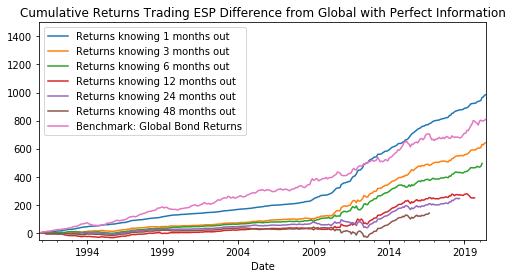

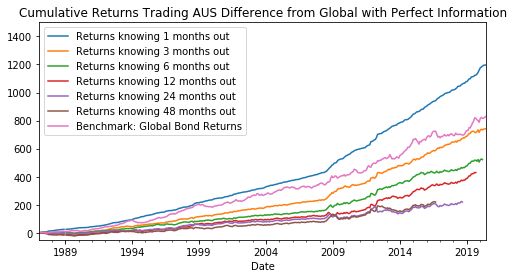

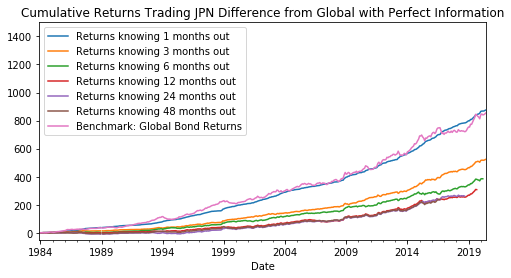

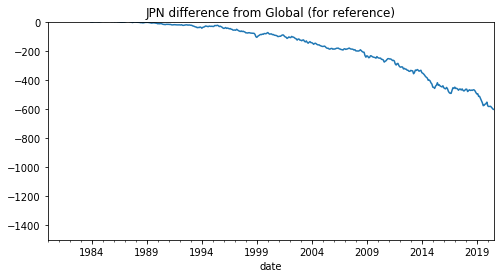

In [34]:
plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['ESP'], 
                      'Cumulative Returns Trading ESP Difference from Global with Perfect Information', 
                      ymax=1500, relativePosStrategy=True)
plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['AUS'], 
                      'Cumulative Returns Trading AUS Difference from Global with Perfect Information', 
                      ymax=1500, relativePosStrategy=True)
plotCumPerfectReturns(MonthList, CumBondReturnDifferenceFromWrldAvg['JPN'], 
                      'Cumulative Returns Trading JPN Difference from Global with Perfect Information', 
                      ymax=1500, relativePosStrategy=True)

CumBondReturnDifferenceFromWrldAvg['JPN'].plot()
plt.title("JPN difference from Global (for reference)")
plt.ylim(-1500, 0)
plt.show()

### TODO: What do returns look like if you had <i>approximately</i> perfect information about the change in a country's relative position X time into the future? (Using Bond Prospectus Strategy)
#### Given that with perfect trading already ^, you already barely beat the global bond return index... this analysis would only be worth pursuing if you know that this return stream has very low correlation with the return stream of holding the global bond market. Intuitively, they should have low correlation, so this analysis could actually be worth pursuing if you just wanted to compliment a global bond hold strategy with this relative position trading strategy

### TODO: Same analysis with trading the relative position of 2 countries, 3 countries, ... instead of just one country's relative position

### TODO: What do returns look like if you had (biased) (approximately) perfect information about the change in a country's long rates X time into the future and used that to bet on global bond return index? This more accurately reflects how we would bet in practice
#### (assuming that long rates and bond return index are inversely correlated)